In [226]:
import requests
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras import layers, models
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np
import os
import random

# Scrape configuration
MAX_PAGES = 3
START_URL = "https://www.nytimes.com/timeswire/"  # Replace with a seed URL
IMAGE_SIZE = (48, 48)
CONTRAST_THRESHOLD = 4.5
OUTPUT_DIR = "scraped_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

driver_path = '/opt/homebrew/bin/chromedriver'
driver = webdriver.Chrome(service=Service(driver_path), options=chrome_options)
driver.set_window_size(1200, 939)

print("start")

# Function to construct the CSS selector
def get_css_selector(element):
    selector = element.name
    
    if element.get('id'):
        selector += f'#{element["id"]}'
    
    if element.get('class'):
        selector += '.' + '.'.join(element["class"])
    
    for attribute, value in element.attrs.items():
        if attribute not in ['id', 'class']:
            selector += f'[{attribute}="{value}"]'
    
    return selector

# Helper functions
def calculate_contrast(image):
    """Calculate contrast ratio using WCAG guidelines."""
    grayscale_image = image.convert('L')
    pixel_values = np.array(grayscale_image)

    min_intensity = pixel_values.min()
    max_intensity = pixel_values.max()
    
    l1 = (max_intensity + 0.05) / 255
    l2 = (min_intensity + 0.05) / 255
    contrast_ratio = (l1 + 0.05) / (l2 + 0.05) if l1 > l2 else (l2 + 0.05) / (l1 + 0.05)
    return contrast_ratio

def scrape_links(url, visited, max_pages=MAX_PAGES):
    """Crawl the web starting from a URL, returning a list of links."""
    to_visit = [url]
    links = []

    while to_visit and len(links) < max_pages:
        current_url = to_visit.pop(0)
        if current_url in visited:
            continue
        
        try:
            driverResponse = driver.get(url)
            response = requests.get(url, timeout=3)
            
            if response.status_code == 200:
                soup = BeautifulSoup(driver.page_source, "html.parser")
                visited.add(current_url)
                links.append(current_url)
                
                # Add new links to the queue
                for anchor in soup.find_all("a", href=True):
                    href = anchor["href"]
                    if href.startswith("http"):
                        to_visit.append(href)
        except Exception as e:
            print(f"Failed to process {current_url}: {e}")
    
    return links[:max_pages]


def screenshot_element(driver, element):
    driver.execute_script("arguments[0].scrollIntoView(true);", element)
    time.sleep(1) 

    # Step 2: Take a screenshot of the entire page
    screenshot_path = "full_page_screenshot.png"
    driver.save_screenshot(screenshot_path)
    
    location = element.location
    size = element.size
    
    # Step 3: Crop the image to the element's location and size
    image = Image.open(screenshot_path)
    image = image.resize((1200, 939), Image.Resampling.LANCZOS)

    width, height = image.size
    
    left = location['x']
    top = 0
    right = min(width, left + size['width']) 
    bottom = min(size['height'], height)

    print(element.text, size)
    
    # Crop the image using Pillow
    cropped_image = image.crop((left, top, right, bottom))

    # Step 4: Save the cropped screenshot
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    element_screenshot_path = os.path.join(OUTPUT_DIR, f"screenshot_{random.randint(1, 1000000)}.png")
    cropped_image.save(element_screenshot_path)

    # Return the path of the cropped screenshot
    return element_screenshot_path

def preprocess_image(image_path):
    """Resize and preprocess image for CNN."""
    image = Image.open(image_path).convert('L')
    image = image.resize((48,48))
    return np.array(image)

def fetch_html(url):
    try:
        driverResponse = driver.get(url)
        time.sleep(3)
        response = requests.get(url, timeout=3)
        response.raise_for_status()  # Will raise an exception for HTTP errors
        return driver.page_source
    except RequestException as e:
        print(f"Error fetching {url}: {e}")

# Scrape and process data
visited_urls = set()
scraped_links = scrape_links(START_URL, visited_urls)

X, y = [], []
for link in scraped_links:
    try:
        html_content = fetch_html(link)
        if html_content:
            soup = BeautifulSoup(html_content, "html.parser")
    
            # Extract elements with text and background styles
            for element in soup.find('body').find_all(['h3']):
                text = element.get_text(strip=True)

                if text and not element.find_all(True):
                    try:
                        css_selector = get_css_selector(element)
                        driverElements = driver.find_elements(By.CSS_SELECTOR, css_selector)
                
                        if driverElements:                        
                            for driverElement in driverElements:
                                screenshot_path = screenshot_element(driver, driverElement)
                                image = preprocess_image(screenshot_path)                        
                                contrast_ratio = calculate_contrast(Image.fromarray(image.squeeze()))
                                X.append(image)
                                y.append(1 if contrast_ratio >= CONTRAST_THRESHOLD else 0)
                    except Exception as e:
                            print(f"Error processing element with selector {css_selector}: {e}")
                else: continue
        else: continue
    except Exception as e:
        print(f"Error processing {link}: {e}")

print(y)

start
Bresnahan Beats Cartwright in Pennsylvania, Handing G.O.P. a Key Seat {'height': 50, 'width': 470}
Mackenzie Beats Wild in Pennsylvania, Scoring a Key Pickup for House G.O.P. {'height': 50, 'width': 470}
Will Trump Have a New Opening to Repeal Obamacare? {'height': 50, 'width': 470}
Voters Poised to Reject Private School Vouchers in Three States {'height': 50, 'width': 470}
Lower Rates, Rising Yields: What to Make of the Bond Market Right Now {'height': 50, 'width': 470}
At Salon Art + Design, Nature and Beauty Come Center Stage {'height': 50, 'width': 470}
No-Rules Friendsgiving {'height': 25, 'width': 470}
Gillen Defeats D’Esposito in New York, Flipping House Seat for Democrats {'height': 50, 'width': 470}
Bresnahan Beats Cartwright in Pennsylvania, Handing G.O.P. a Key Seat {'height': 50, 'width': 470}
Mackenzie Beats Wild in Pennsylvania, Scoring a Key Pickup for House G.O.P. {'height': 50, 'width': 470}
Will Trump Have a New Opening to Repeal Obamacare? {'height': 50, 'width

[1 1 0 ... 0 0 0]
Epoch 1/5


/opt/anaconda3/envs/tensor/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6557 - loss: 15.6552 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9835 - loss: 0.0954 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9949 - loss: 0.0256 - val_accuracy: 1.0000 - val_loss: 8.2358e-04
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9966 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9894 - loss: 0.0318 - val_accuracy: 1.0000 - val_loss: 8.7428e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011 
Loss: 0.0008742809877730906, Accuracy: 1.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


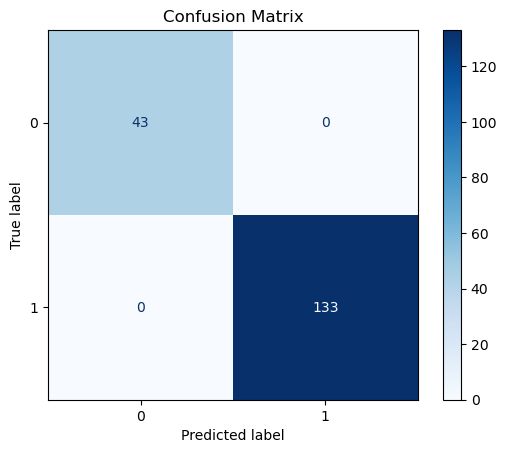

Confusion Matrix:
 [[ 43   0]
 [  0 133]]
INFO:tensorflow:Assets written to: HTMLConvolutional/assets


INFO:tensorflow:Assets written to: HTMLConvolutional/assets


Saved artifact at 'HTMLConvolutional'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor_60')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  13580467664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580457872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580457680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580458064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580456720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580455760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580453456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580466128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580452496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13580465936: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [217]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split and balance the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_distribution = Counter(y_train)

# Get the number of samples in the minority class
min_class = min(class_distribution, key=class_distribution.get)
min_class_samples = class_distribution[min_class]

smote = SMOTE(sampling_strategy='auto', k_neighbors=min(3, min_class_samples))

X_flattened = X_train.reshape(X_train.shape[0], -1)
X_resampled, y_resampled = smote.fit_resample(X_flattened, y_train)  
X_shaped = X_resampled.reshape(X_resampled.shape[0], *IMAGE_SIZE, 1)
                     
# Define the CNN
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN
print(y_resampled)

cnn_model.fit(X_shaped, y_resampled, epochs=5, validation_data=(X_test, y_test))

# Evaluate the CNN
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

predictions = cnn_model.predict(X_test)

# Step 2: Get predicted classes
# For binary classification (0 or 1)
predicted_classes = np.argmax(predictions, axis=1)

# Step 3: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Step 4: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print out the confusion matrix
print('Confusion Matrix:\n', conf_matrix)

cnn_model.export("HTMLConvolutional")